*Copyright (C) 2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Satellite Scheduler Tech Demo
This notebook demonstrates the usage of a Lava-Optimization QUBO solver to schedule requests for a constellation of Earth Observation satellites.
The notebook uses the SatelliteSchedulingProblem API to generate synthetic problem instances, convert the problems into QUBO matrices, and then run
the Lava solver to find a satisfactory schedule.

### Scenario Description
Earth Observation satellites orbit the Earth on fixed trajectories with each orbital pass taking between 30 minutes and a few hours. During an orbit,
the satellite can reorient itself to observe different positions on the Earth's surface with its sensors. The ability to reorient is limited by
the satellite's actuators to a maximum rotational rate. For a given satellite to satisfy two sequential observation requests, there must be adequate
time between the requests for the satellite to reorient without exceeding its maximum rotational rate. For simple orbits, the time between requests
is essentially determined by the difference in longitude coordinates of the two requests, divided by the longitudinal velocity of the satellite.

<center><img src="attachment:2ca9df77-5799-445f-b8d7-4f1f93d0e9e1.png" width="500"/></center>

### Solution Strategy
The physical constraints of the satellite scheduling problem can be mapped into QUBO by creating a graph corresponding to the vehicles and requests
that are currently being scheduled. Any two requests which cannot be observed by the same vehicle will be connected in the graph by an edge,
indicating a hard constraint between those requests. Using a QUBO solver, we can then find a Maximal Independent Set of the graph, corresponding
to a locally-optimal schedule. This method of scheduling requests for a constellation of satellites can scale up to create schedules for larger
constellations receiving more requests than a conventional scheduling algorithm.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from lava.lib.optimization.apps.scheduler.problems import SatelliteScheduleProblem
from lava.lib.optimization.apps.scheduler.solver import SatelliteScheduler

#### Create a SchedulingProblem object

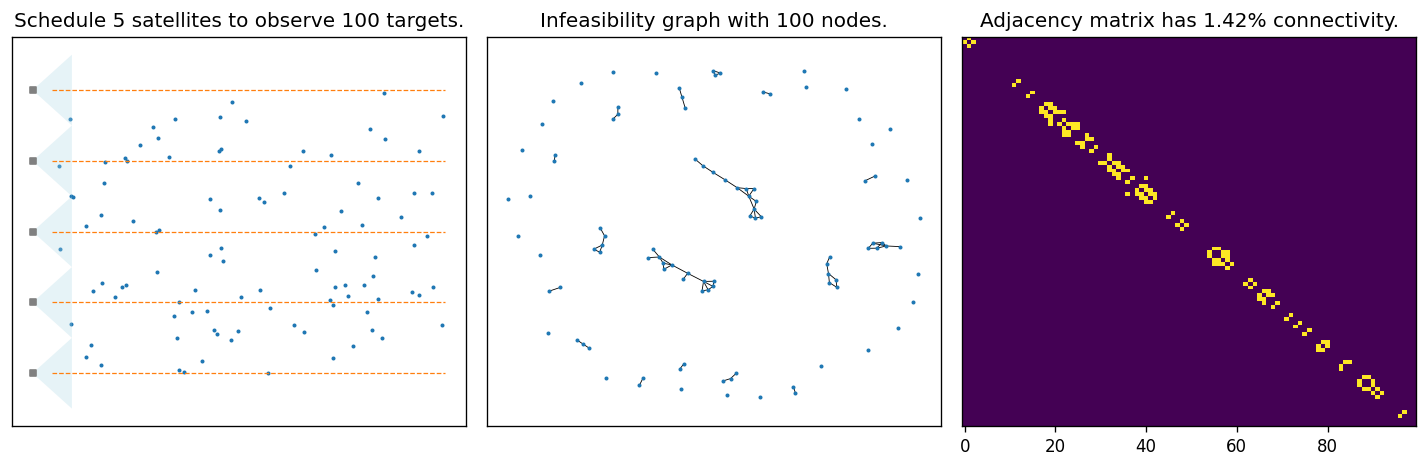

In [2]:
scheduling_problem = SatelliteScheduleProblem(num_satellites=5,
                                              num_requests=100)
scheduling_problem.view_height = 0.25
scheduling_problem.generate(42)
scheduling_problem.plot_problem()

#### Create a Scheduler object
Scheduler consumes a SchedulingProblem along with QUBO specific parameters

In [3]:
scheduler = SatelliteScheduler(scheduling_problem,
                               qubo_weights=(4, 20),
                               probe_loihi_exec_time=True)

##### Solve using NetworkX module

In [4]:
scheduler.solve_with_netx()
print(f'Scheduled {scheduler.netx_solution.shape[0]} Requests.')

Scheduled 63 Requests.


##### Solve using Lava QUBO Solver on Loihi 2

In [5]:
#os.environ["LOIHI_GEN"]="N3B3"
#os.environ["PARTITION"]="kp_dev"
#os.environ["SLURM"]="1"

In [6]:
scheduler.qubo_hyperparams = ({"temperature": 1},
                              True)
scheduler.lava_backend = "Loihi2"
scheduler.solve_with_lava_qubo(timeout=1000)

Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.62%|  12.50%|   0.02%|   0.62%|   0.01%|   0.00%|   1.02%|       1|
|   0.45%|  12.50%|   2.44%|   0.49%|   1.25%|   0.00%|   2.25%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       2|
-------------------------------------------------------------------------


/home/ncluser/lava-nc/nxcore-2.3.0/nxcore/arch/n3b/n3board.py:54: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  Running in non-slurm environment on : 192.168.8.150
INFO:DRV:  Connecting to 192.168.8.150:39901
INFO:DRV:      Host server up..............Done 1.59s
INFO:DRV:      Mapping chipIds.............Done 0.08ms
INFO:DRV:      Mapping coreIds.............Done 0.22ms
INFO:DRV:      Partitioning neuron groups..Done 5.94ms
INFO:DRV:      Mapping axons...............Done 3.96ms
INFO:DRV:      Writes SpikeIO Config to FileDone 0.04ms
INFO:DRV:      Partitioning MPDS...........Done 6.06ms
INFO:DRV:      Creating Embedded Snips and ChannelsDone 2.70ms
INFO:DRV:      Compiling Embedded snips....Done 0.77s
INFO:DRV:      Compiling Host snips........Done 0.15ms
INFO:DRV:      Compiling Register Probes...Done 0.21ms
INFO:DRV:      Compiling Spike Probes......Done 0.03ms
INFO:HST:  Args chip=0 cpu=0 /tmp/launcher_chip0_cpu0.bin --chips=1 --remote-relay=0 
INFO:DRV:      Booting up..................Done 0.64s
INFO:HST:  Args chip=0 cpu=1 /tmp/launcher_chip0_cpu1.bin --chips=1 --remote-relay=0 

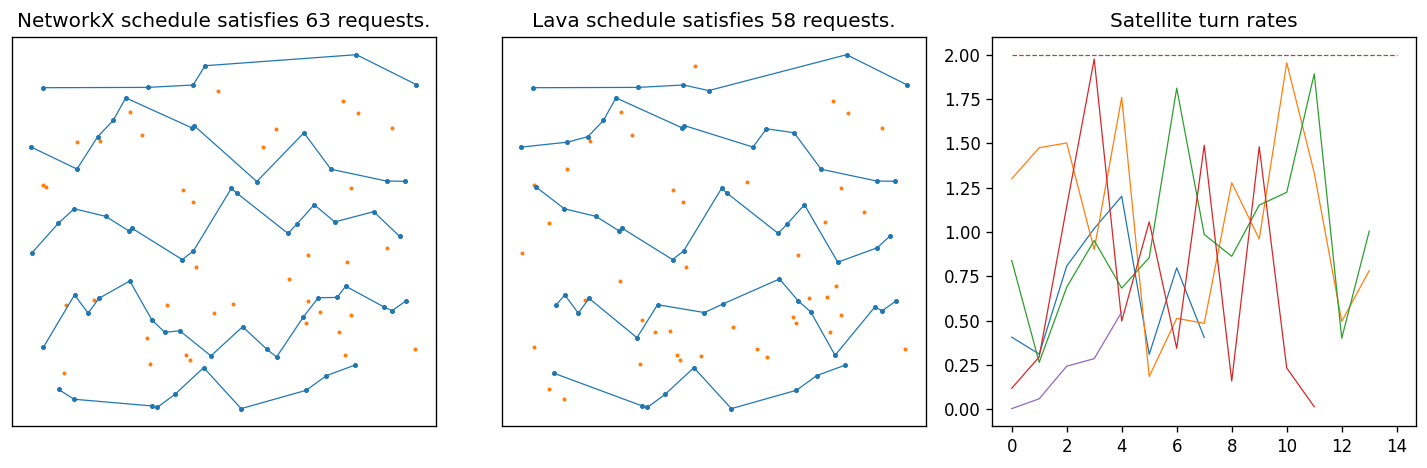

In [7]:
scheduler.plot_solutions()

In [8]:
scheduler.lava_solver_report.profiler.execution_time.sum()

0.007259